# Experiment Notebook: Sanity Checks

# Table of Contents
* [Experiment Summary](#Experiment-Summary)
* [Experiment Assumptions](#Experiment-Assumptions)
* [Experiment Setup](#Experiment-Setup)
* [Analysis 1: PCV Sanity Checks](#Analysis-1:-PCV-Sanity-Checks)

# Experiment Summary 

The purpose of this notebook is to...

# Experiment Assumptions

See [assumptions document](../../ASSUMPTIONS.md) for further details.

# Experiment Setup

We begin with several experiment-notebook-level preparatory setup operations:

* Import relevant dependencies
* Import relevant experiment templates
* Create copies of experiments
* Configure and customize experiments 

Analysis-specific setup operations are handled in their respective notebook sections.

In [1]:
# Import the setup module:
# * sets up the Python path
# * runs shared notebook configuration methods, such as loading IPython modules
import setup

import copy
import logging
import numpy as np
import pandas as pd
import plotly.express as px

import experiments.notebooks.visualizations as visualizations
from experiments.run import run
from experiments.utils import display_code

time: 1.04 s (started: 2022-08-02 14:57:33 +02:00)


In [2]:
# Enable/disable logging
logger = logging.getLogger()
logger.disabled = False
logging.disable(logging.DEBUG)

time: 24.3 ms (started: 2022-08-02 14:57:34 +02:00)


In [3]:
# Import experiment templates
import experiments.default_experiment as default_experiment

time: 29.5 ms (started: 2022-08-02 14:57:34 +02:00)


In [4]:
# Create a simulation for each analysis
simulation_1 = copy.deepcopy(default_experiment.experiment.simulations[0])

time: 32.7 ms (started: 2022-08-02 14:57:34 +02:00)


In [5]:
# Experiment configuration
simulation_1.model.initial_state.update({})

simulation_1.model.params.update({})

time: 29.4 ms (started: 2022-08-02 14:57:34 +02:00)


# Analysis 1: Fei Protocol Model Sanity Checks

A simulation across 4 volatile asset price scenarios to validate key model states and metrics.

In [6]:
# Analysis-specific setup
simulation_1.model.params.update({
    # Disable policy by setting to `None`
    "target_stable_pcv_ratio": [None],
    "target_stable_backing_ratio": [None],
    "volatile_asset_price_process": [
        lambda _run, _timestep: 2_000,
        lambda _run, timestep: 2_000 if timestep < 365 / 4 else (1_000 if timestep < 365 * 3/4 else 2_000),
        lambda _run, timestep: 2_000 * (1 + timestep * 0.2 / 365),
        lambda _run, timestep: 2_000 * (1 - timestep * 0.2 / 365),
    ],
})

time: 27 ms (started: 2022-08-02 14:57:34 +02:00)


In [7]:
# Experiment execution
df, exceptions = run(simulation_1)

2022-08-02 14:57:34,641 - root - INFO - Running experiment
2022-08-02 14:57:34,759 - root - INFO - Setting up initial state
2022-08-02 14:57:34,768 - root - INFO - Setting up initial state
2022-08-02 14:57:34,774 - root - INFO - Setting up initial state
2022-08-02 14:57:34,779 - root - INFO - Setting up initial state
2022-08-02 14:57:34,841 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-08-02 14:57:34,860 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-08-02 14:57:34,883 - root - INFO - Starting simulation 0 / run 0 / subset 2
2022-08-02 14:57:34,911 - root - INFO - Starting simulation 0 / run 0 / subset 3
2022-08-02 14:57:39,837 - root - INFO - Experiment complete in 5.194091558456421 seconds
2022-08-02 14:57:39,837 - root - INFO - Post-processing results
2022-08-02 14:57:42,506 - root - INFO - Post-processing complete in 2.669443130493164 seconds
time: 7.9 s (started: 2022-08-02 14:57:34 +02:00)


In [8]:
# Post-processing and visualizations

time: 35.4 ms (started: 2022-08-02 14:57:42 +02:00)


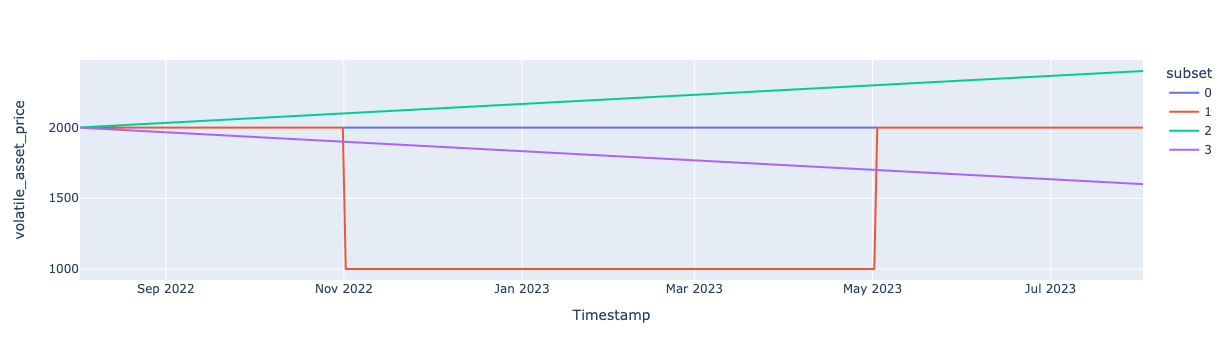

time: 992 ms (started: 2022-08-02 14:57:42 +02:00)


In [9]:
fig = df.plot(y='volatile_asset_price', color='subset')

fig.update_xaxes(title='Timestamp')

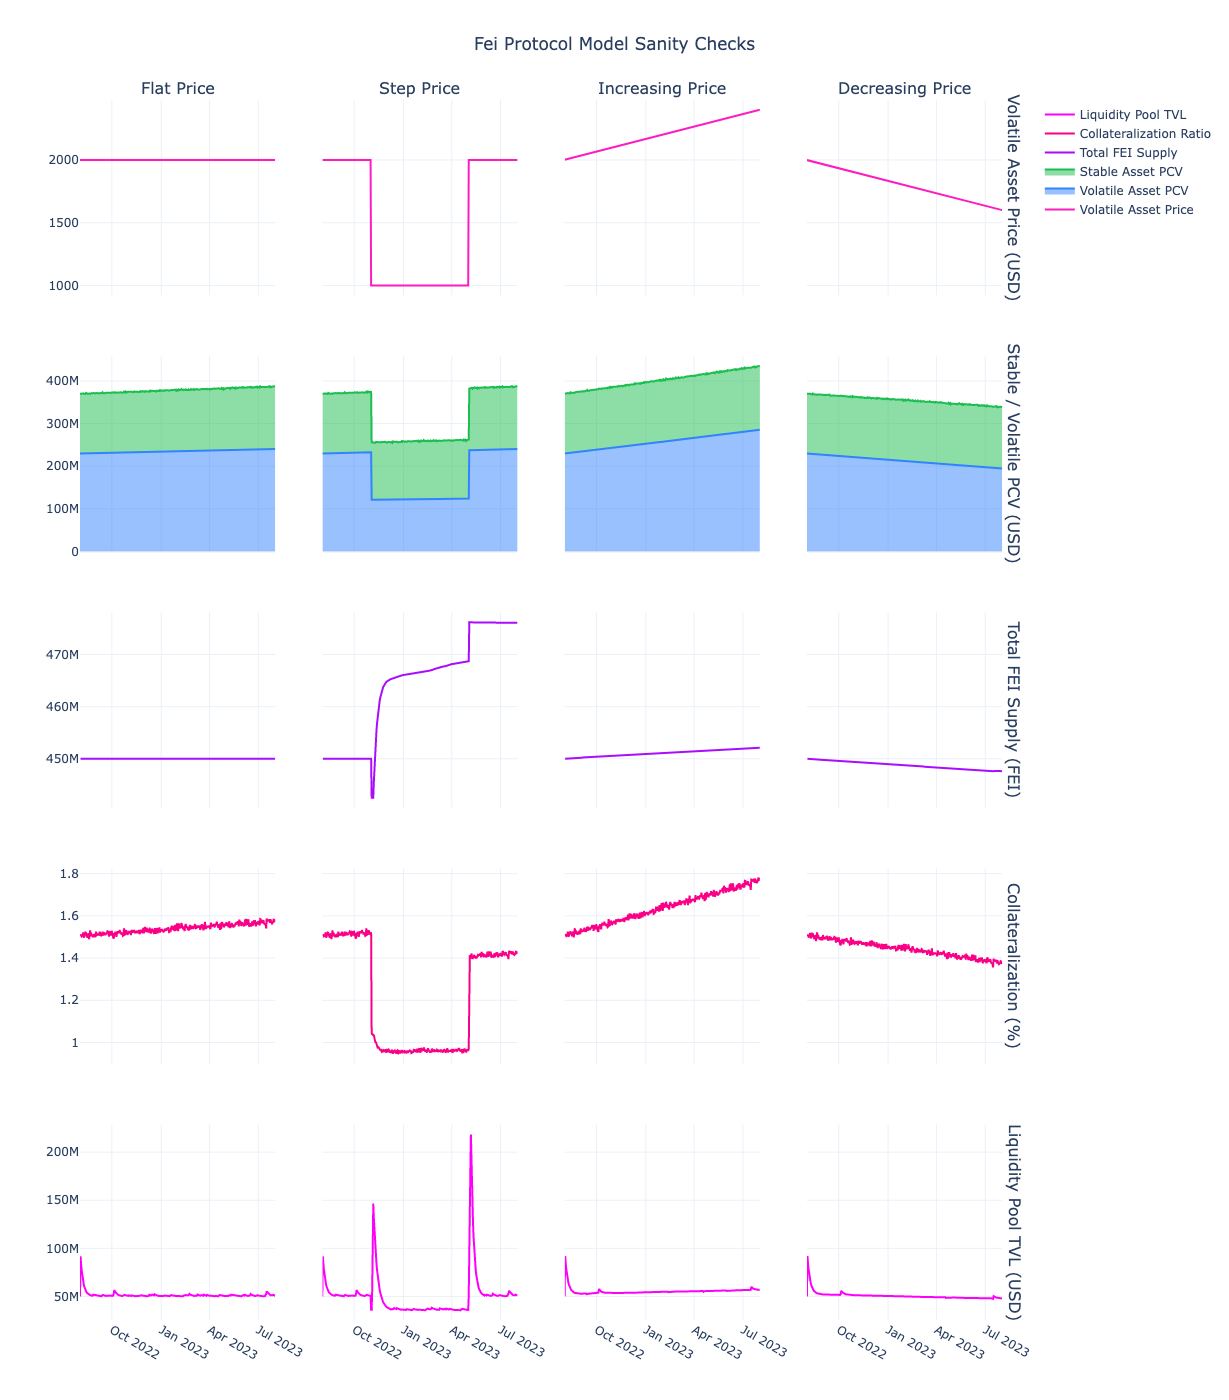

time: 996 ms (started: 2022-08-02 14:57:43 +02:00)


In [10]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
from experiments.notebooks.visualizations.plotly_theme import cadlabs_colorway_sequence
color_cycle = itertools.cycle(cadlabs_colorway_sequence)


column_titles = [
    "Flat Price",
    "Step Price",
    "Increasing Price",
    "Decreasing Price"
]
row_titles = [
    "Volatile Asset Price (USD)",
    "Stable / Volatile PCV (USD)",
    "Total FEI Supply (FEI)",
    "Collateralization (%)",
    "Liquidity Pool TVL (USD)",
]

fig = make_subplots(
    rows=5,
    cols=len(df.subset.unique()),
    shared_xaxes=True,
    shared_yaxes="rows",
    horizontal_spacing=0.05,
    vertical_spacing=0.05,
    column_titles=column_titles,
    row_titles=row_titles,
)

for subset in df.subset.unique():
    df_plot = df.query('subset == @subset')
    
    show_legend = bool(subset == 0)
    column = subset + 1
    
    row = 1
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.volatile_asset_price,
            name="Volatile Asset Price",
            line=dict(color=cadlabs_colorway_sequence[row - 1]),
            showlegend=show_legend,
        ),
        row=row, col=column,
    )
    
    row = 2
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_volatile_asset_pcv,
            name="Volatile Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[row - 1]),
            showlegend=show_legend,
            stackgroup='one',
        ),
        row=row, col=column
    )
    
    row = 2
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_stable_asset_pcv,
            name="Stable Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[row]),
            showlegend=show_legend,
            stackgroup='one',
        ),
        row=row, col=column
    )
    
    row = 3
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_fei_supply,
            name="Total FEI Supply",
            line=dict(color=cadlabs_colorway_sequence[row]),
            showlegend=show_legend,
        ),
        row=row, col=column
    )
    
    row = 4
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.collateralization_ratio,
            name="Collateralization Ratio",
            line=dict(color=cadlabs_colorway_sequence[row]),
            showlegend=show_legend,
        ),
        row=row, col=column
    )
    
    row = 5
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.liquidity_pool_tvl,
            name="Liquidity Pool TVL",
            line=dict(color=cadlabs_colorway_sequence[row]),
            showlegend=show_legend,
        ),
        row=row, col=column
    )

fig.update_layout(height=1400, title_text="Fei Protocol Model Sanity Checks")
fig.show()

# Analysis 2: Liquidity Pool Sanity Checks

Evaluating the second subset, a step in the volatile asset price, we expect the following results:

1. A step in the volatile asset price results in an imbalance in the liquidity pool, which is rebalanced by:
 - Step down in volatile asset price results in an excess of FEI in the pool: FEI is released from the liquidity pool into the circulating supply and **redeemed**
 - Step up in volatile asset price results in a deficit of FEI in the pool: FEI is **minted** and deposited into the liquidity pool
2. The rebalancing transaction volume causes a spike in transaction fees collected and resulting liquidity pool yield rate
3. The capital allocation weights for the liquidity pool increase
4. The capital allocation Model moves user FEI into the liquidity pool

In [11]:
df_subset_1 = df.query("subset == 1")

time: 48.8 ms (started: 2022-08-02 14:57:44 +02:00)


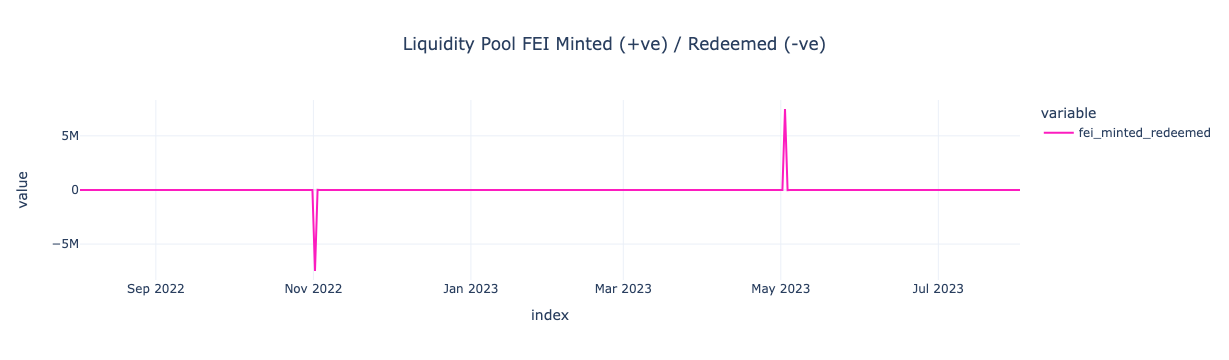

time: 141 ms (started: 2022-08-02 14:57:44 +02:00)


In [12]:
df_subset_1.plot(
    title='Liquidity Pool FEI Minted (+ve) / Redeemed (-ve)',
    y=['fei_minted_redeemed'],
)

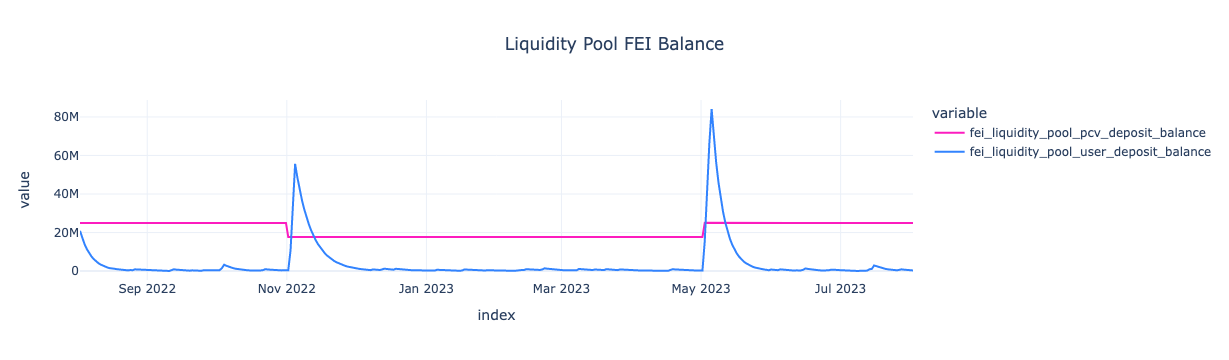

time: 121 ms (started: 2022-08-02 14:57:44 +02:00)


In [13]:
df_subset_1.plot(
    title='Liquidity Pool FEI Balance',
    y=['fei_liquidity_pool_pcv_deposit_balance', 'fei_liquidity_pool_user_deposit_balance'],
)

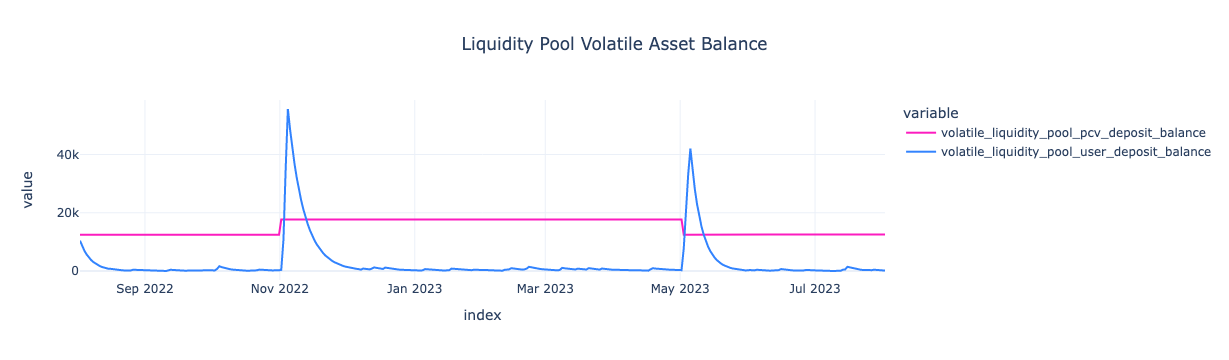

time: 129 ms (started: 2022-08-02 14:57:45 +02:00)


In [14]:
df_subset_1.plot(
    title='Liquidity Pool Volatile Asset Balance',
    y=['volatile_liquidity_pool_pcv_deposit_balance', 'volatile_liquidity_pool_user_deposit_balance'],
)

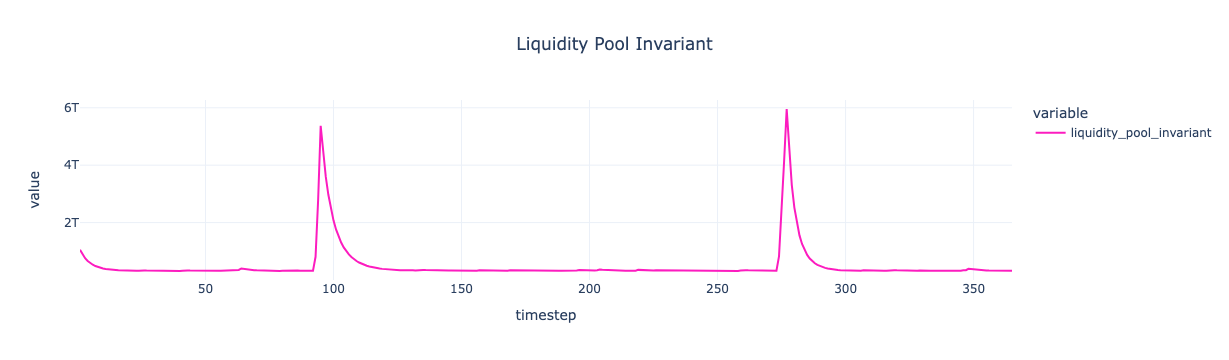

time: 72.2 ms (started: 2022-08-02 14:57:45 +02:00)


In [15]:
df_subset_1.plot(
    title='Liquidity Pool Invariant',
    x='timestep',
    y=['liquidity_pool_invariant'],
)

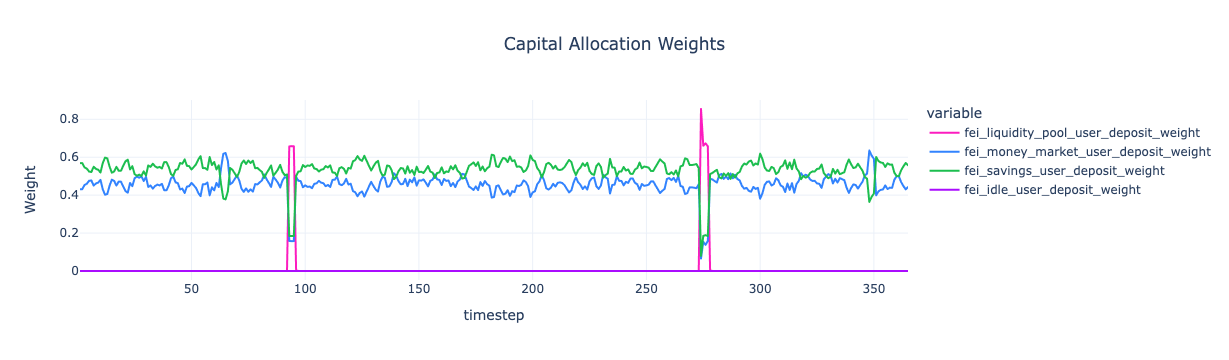

time: 121 ms (started: 2022-08-02 14:58:04 +02:00)


In [18]:
from model.system_parameters import parameters

capital_allocation_fei_deposit_variables = parameters['capital_allocation_fei_deposit_variables'][0]
capital_allocation_weights = [f"{key}_weight" for key in capital_allocation_fei_deposit_variables]

df_subset_1.groupby('timestep').mean().plot(
    title = 'Capital Allocation Weights',
    labels = {"value": "Weight"},
    y = capital_allocation_weights,
)